In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import numpy as np
import geopandas
import csv

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

/Users/allisonmorgan/Dropbox/Faculty Social Mobility/code/plot_utils.py:39: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [


In [2]:
respondents_zip = pd.read_csv('../data/coded_data/data_linked.csv')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (40,139,142,144,152,157,163,164,167,168,169,188,189,190,204,206,207,208,209,210,215,216,232,233,240,244,245,246,247,248,249,250,251,252,253,254,255) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
respondents_zip['zip'] = respondents_zip['zip'].astype(str)
#respondents_zip.head()

In [4]:
# http://geojson.xyz
states = geopandas.read_file('../data/geography/ne_110m_admin_1_states_provinces_shp.geojson')

In [5]:
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
zips = geopandas.read_file('../data/geography/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')

In [6]:
zips['centroids'] = zips.centroid

<ipython-input-6-ff829f2592a6>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zips['centroids'] = zips.centroid


In [7]:
def haversine(coord1, coord2):
    # https://en.wikipedia.org/wiki/Haversine_formula
    import math
    R = 3958.8  # radius of Earth in miles
    
    lon1, lat1 = coord1.x, coord1.y
    lon2, lat2 = coord2.x, coord2.y
    
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    
    lambda_1 = math.radians(lon1)
    lambda_2 = math.radians(lon2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2
    b = math.cos(phi_1)*math.cos(phi_2)*(math.sin(delta_lambda/2)**2)
    d = 2*R*math.asin(math.sqrt(a + b))
    return d

In [8]:
zips['profs_per_zip'] = zips['ZCTA5CE10'].apply(lambda x: len(respondents_zip[respondents_zip['zip'] == x]))

In [9]:
# https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
irs_data = pd.read_csv('../data/irs_data/yearly_irs_zip_data.csv', dtype={'ZIPCODE': str}, low_memory=False)
irs_data = irs_data[irs_data['ZIPCODE'].notna()]

irs_data['INFADJ_AGI'] = irs_data['INFADJ_AGI'].astype(float)
irs_data['AGI'] = irs_data['AGI'].astype(float)
irs_data['N'] = irs_data['N'].astype(float)
irs_data['AVG_ADJ_AGI'] = irs_data['INFADJ_AGI']/irs_data['N']

irs_data_98 = irs_data[irs_data['YEAR'] == 1998]

In [10]:
zips['returns_per_zip'] = zips.merge(irs_data_98, left_on = 'ZCTA5CE10', right_on = 'ZIPCODE')['N']

In [11]:
zips['profs_per_cap'] = np.divide(zips['profs_per_zip'], zips['returns_per_zip'])
zips['profs_per_cap_scaled'] = zips['profs_per_cap']/zips['profs_per_cap'].max()

In [12]:
dict(zips['profs_per_zip'].value_counts()), zips['profs_per_zip'].mean()

({0: 30650,
  1: 1918,
  2: 382,
  3: 113,
  4: 42,
  5: 17,
  6: 11,
  7: 3,
  8: 3,
  10: 3,
  9: 1,
  12: 1},
 0.10366883900555153)

In [13]:
len(zips[zips['profs_per_zip'] > 0]['ZCTA5CE10'].unique()), \
zips[zips['profs_per_zip'] > 0]['profs_per_zip'].mean(), \
dict(zips[zips['profs_per_zip'] > 0]['profs_per_zip'].value_counts(normalize=True))

(2494,
 1.3777064955894145,
 {1: 0.7690457097032879,
  2: 0.15316760224538895,
  3: 0.045308740978348035,
  4: 0.016840417000801924,
  5: 0.00681635926222935,
  6: 0.004410585404971933,
  8: 0.0012028869286287089,
  10: 0.0012028869286287089,
  7: 0.0012028869286287089,
  12: 0.00040096230954290296,
  9: 0.00040096230954290296})

In [14]:
# fig, ax = plt.subplots(1,1, figsize = plot_utils.SINGLE_FIG_SIZE)
# scale = 15.0

# zips_copy = zips.copy(deep=True)

# states.plot(ax=ax, color='white', edgecolor=plot_utils.LIGHT_COLOR, linewidth=0.5)

# zips.plot(column='profs_per_zip', ax=ax, cmap='Greens', 
#           missing_kwds={"color": "lightgrey", "edgecolor": None, "hatch": "///"}) 

# plt.xlim(-125, -66)
# plt.ylim(25, 50)

# ax.set_axis_off()
# plot_utils.finalize(ax)

# plt.tight_layout()
# # plt.savefig('../plots/professors_map_chloropleth.pdf', dpi=1000)
# plt.show()

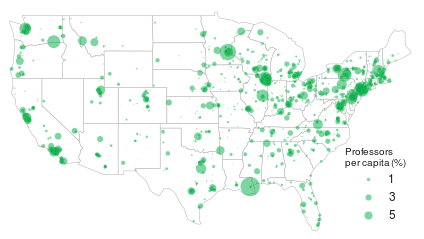

In [15]:
fig, ax = plt.subplots(1,1, figsize = plot_utils.SINGLE_FIG_SIZE)
scale = 15.0

zips_copy = zips.set_geometry('centroids')
zips_copy = zips_copy[zips_copy['profs_per_zip'] >= 1]

states.plot(ax = ax, color='white', edgecolor=plot_utils.LIGHT_COLOR, linewidth=0.5)
#zips.plot(ax=ax, linewidth=0.5, edgecolor=plot_utils.LIGHT_COLOR, color='white', alpha=0.1)
zips_copy.plot(ax=ax, legend=True, linewidth=0.1, edgecolor='white', alpha=0.5,
               markersize=zips_copy['profs_per_cap']*100.0*scale, color=plot_utils.ACCENT_COLOR)

plt.xlim(-125, -66)
plt.ylim(25, 50)

l1 = plt.scatter([],[], s=1.0*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR, alpha=0.5)
l2 = plt.scatter([],[], s=3.0*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR, alpha=0.5)
l3 = plt.scatter([],[], s=5.0*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR, alpha=0.5)

labels = ["%.0f" % 1.0, "%.0f" % 3.0, "%.0f" % 5.0]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=False, fontsize=plot_utils.LEGEND_SIZE,
           handlelength=2, loc='lower right', title='Professors\nper capita (\%)',
           scatterpoints=1)

ax.set_axis_off()
plot_utils.finalize(ax)

plt.tight_layout()
plt.savefig('../plots/professors_map_per_capita.pdf', dpi=1000)
plt.show()

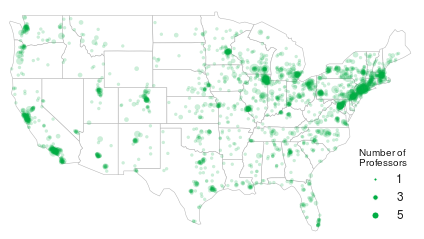

In [16]:
fig, ax = plt.subplots(1,1, figsize = plot_utils.SINGLE_FIG_SIZE)
scale = 10

zips_copy = zips.set_geometry('centroids')
zips_copy = zips_copy[zips_copy['profs_per_zip'] >= 1]

states.plot(ax = ax, color='white', edgecolor=plot_utils.LIGHT_COLOR, linewidth=0.5)
#zips.plot(ax=ax, linewidth=0.5, edgecolor=plot_utils.LIGHT_COLOR, color='white', alpha=0.1)
zips_copy.plot(ax=ax, legend=True, linewidth=0.1, edgecolor=None, alpha=0.2,
               markersize=(zips_copy['profs_per_zip'])*scale, color=plot_utils.ACCENT_COLOR)

plt.xlim(-125, -66)
plt.ylim(25, 50)

l1 = plt.scatter([],[], s=1*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR)
l2 = plt.scatter([],[], s=3*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR)
l3 = plt.scatter([],[], s=5*scale, edgecolors='white', color=plot_utils.ACCENT_COLOR)

labels = ["%.0f" % 1.0, "%.0f" % 3.0, "%.0f" % 5.0]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=False, fontsize=plot_utils.LEGEND_SIZE,
           handlelength=2, loc='lower right', title='Number of\nProfessors',
           scatterpoints=1)

ax.set_axis_off()
plot_utils.finalize(ax)

plt.tight_layout()
plt.savefig('../plots/professors_map.pdf', dpi=1000)
plt.show()

### Distance traveled from home to work

In [17]:
homes, works = respondents_zip['zip'].values, respondents_zip['inst_zip_inv'].values

In [18]:
home_centroids = [zips[zips['ZCTA5CE10'] == home]['centroids'].values for home in homes]
work_centroids = [zips[zips['ZCTA5CE10'] == work]['centroids'].values for work in works]

In [19]:
# To do: add current instituion zip
dict(respondents_zip['zip'].isna().value_counts())

{False: 8009}

In [20]:
respondents_zip['distance_traveled'] = [haversine(home[0], work_centroids[i][0]) 
                                        if ((len(home) == 1) & (len(work_centroids[i]) == 1))
                                        else np.nan for i, home in enumerate(home_centroids)]

In [21]:
lower_quarter = respondents_zip['distance_traveled'] <= respondents_zip['distance_traveled'].quantile(0.25)
upper_quarter = respondents_zip['distance_traveled'] > respondents_zip['distance_traveled'].quantile(0.75)

lower_dist = respondents_zip[lower_quarter]['parents_highest_edu_coded'].value_counts().sort_index()
upper_dist = respondents_zip[upper_quarter]['parents_highest_edu_coded'].value_counts().sort_index()
# print(lower_dist, '\n\n', upper_dist)

print(chi2_contingency([lower_dist.values, upper_dist.values], correction=False))

(9.955279860993867, 0.12654795845920622, 6, array([[ 30.96050955,  69.41146497,  91.88280255,   3.4955414 ,
          5.49299363,  58.42547771, 132.33121019],
       [ 31.03949045,  69.58853503,  92.11719745,   3.5044586 ,
          5.50700637,  58.57452229, 132.66878981]]))


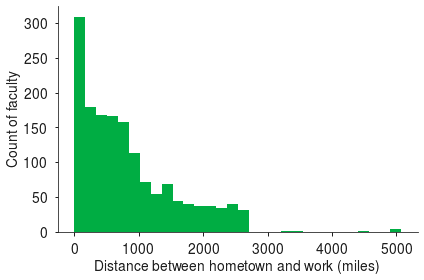

In [22]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
respondents_zip['distance_traveled'].hist(ax=ax, grid=False, bins=30, color=plot_utils.ACCENT_COLOR)
ax.set_ylabel('Count of faculty')
ax.set_xlabel('Distance between hometown and work (miles)')
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/distance.pdf', dpi=1000)

KstestResult(statistic=0.048125667372291916, pvalue=0.0008697217012533232)

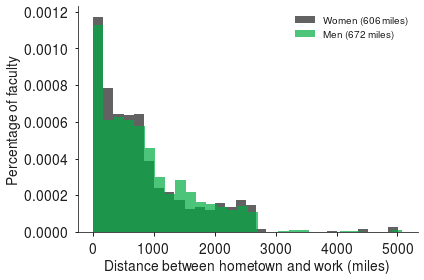

In [23]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
respondents_zip[respondents_zip.gender_ans =='Female']['distance_traveled'].hist(
    ax=ax, grid=False, bins=30, color=plot_utils.ALMOST_BLACK, alpha=0.7, 
    label='Women (%.0f miles)' % respondents_zip[respondents_zip.gender_ans=='Female']['distance_traveled'].median(),
    density=True)
respondents_zip[respondents_zip.gender_ans =='Male']['distance_traveled'].hist(
    ax=ax, grid=False, bins=30, color=plot_utils.ACCENT_COLOR, alpha=0.7, 
    label='Men (%.0f miles)' % respondents_zip[respondents_zip.gender_ans=='Male']['distance_traveled'].median(),
    density=True)
ax.set_ylabel('Percentage of faculty')
ax.set_xlabel('Distance between hometown and work (miles)')

plt.legend(frameon=False)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/distance_gender.pdf', dpi=1000)

ks_2samp(respondents_zip[respondents_zip.gender_ans =='Female']['distance_traveled'], 
         respondents_zip[respondents_zip.gender_ans =='Male']['distance_traveled'])

Avg. distance traveled (std)
PhD parents			 873.19 (839.65)
Masters parents			 902.20 (822.52)
Bachelors parents		 817.56 (714.46)
Less than college parents	 758.47 (699.68)


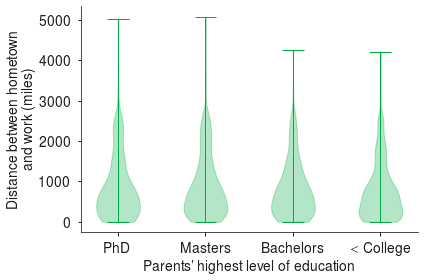

In [24]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE, sharex=True, sharey=True)

phd_parents = respondents_zip[(respondents_zip.parents_highest_edu_coded == 'Doctoral degree') & \
                              ~respondents_zip.distance_traveled.isna()].copy()

master_parents = respondents_zip[
    (respondents_zip.parents_highest_edu_coded == "Master's or professional degree") & \
    ~respondents_zip.distance_traveled.isna()].copy()

bachelor_parents = respondents_zip[(respondents_zip.parents_highest_edu_coded == "College: 4+ years") & \
                                  ~respondents_zip.distance_traveled.isna()].copy()

less_bachelor_parents = respondents_zip[
    ((respondents_zip.parents_highest_edu_coded == "College: 1-3 years") | \
     (respondents_zip.parents_highest_edu_coded == "High school: 4 years") | \
     (respondents_zip.parents_highest_edu_coded == "High school: 1-3 years") | \
     (respondents_zip.parents_highest_edu_coded == "Elementary: 5-8 years") | \
     (respondents_zip.parents_highest_edu_coded == "Elementary: 0-4 years")) & \
    ~respondents_zip.distance_traveled.isna()].copy()

print('Avg. distance traveled (std)')
print('PhD parents\t\t\t %.2f (%.2f)' % 
      (phd_parents['distance_traveled'].mean(), phd_parents['distance_traveled'].std()))
print('Masters parents\t\t\t %.2f (%.2f)' % 
      (master_parents['distance_traveled'].mean(), master_parents['distance_traveled'].std()))
print('Bachelors parents\t\t %.2f (%.2f)' % 
      (bachelor_parents['distance_traveled'].mean(), bachelor_parents['distance_traveled'].std()))
print('Less than college parents\t %.2f (%.2f)' % 
      (less_bachelor_parents['distance_traveled'].mean(), less_bachelor_parents['distance_traveled'].std()))
violin_parts = ax.violinplot([(phd_parents['distance_traveled']).values, 
                              (master_parents['distance_traveled']).values,
                              (bachelor_parents['distance_traveled']).values, 
                              (less_bachelor_parents['distance_traveled']).values])
    
plt.setp(violin_parts['bodies'], facecolor=plot_utils.ACCENT_COLOR, edgecolor=plot_utils.ACCENT_COLOR)

for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor(plot_utils.ACCENT_COLOR)
    vp.set_linewidth(1)

# plt.legend(frameon=False, title="Parents' highest level of education")
ax.set_xlabel("Parents' highest level of education")
ax.set_ylabel('Distance between hometown\nand work (miles)')
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['PhD', 'Masters', 'Bachelors', '$<$ College'])

plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/distance_by_parent_edu.pdf', dpi=1000)

In [25]:
temp = respondents_zip[~respondents_zip.parents_highest_edu_coded.isna()]
phd_dist = temp[temp.parents_highest_edu_coded == 'Doctoral degree']['distance_traveled']
not_phd_dist = temp[temp.parents_highest_edu_coded != 'Doctoral degree']['distance_traveled']

np.mean(phd_dist), np.mean(not_phd_dist), len(not_phd_dist) + len(phd_dist), ks_2samp(phd_dist, not_phd_dist)

(873.1923405020165,
 835.4777234515269,
 7209,
 KstestResult(statistic=0.01124841776023812, pvalue=0.9969037684889425))

In [26]:
# respondents_zip[respondents_zip['distance_traveled'] > 3100][['zip', 'inst_zip_inv']]

In [27]:
respondents_zip['distance_traveled'].isna().value_counts()

True     6435
False    1574
Name: distance_traveled, dtype: int64

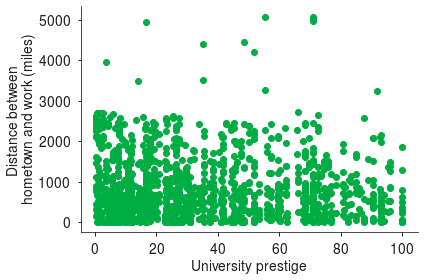

In [28]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
ax.scatter(respondents_zip.rank_scaled, respondents_zip.distance_traveled, color=plot_utils.ACCENT_COLOR)
ax.set_xlabel('University prestige')
ax.set_ylabel('Distance between\nhometown and work (miles)')
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/distance_vs_prestige.pdf', dpi=1000)

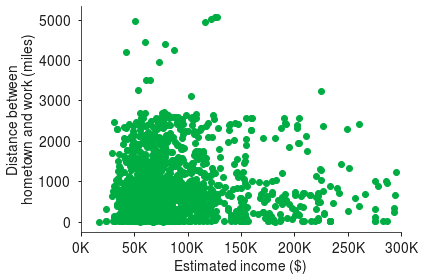

In [29]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
ax.scatter(x=respondents_zip['avg_income']*1000, y=respondents_zip['distance_traveled'], color=plot_utils.ACCENT_COLOR)
ax.set_xlabel('Estimated income (\$)')
ax.set_ylabel('Distance between\nhometown and work (miles)')

plt.xlim([0, 300000])
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000], 
           [r'$0K$', r'$50K$', r'$100K$', r'$150K$', r'$200K$', r'$250K$', r'$300K$'])

plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/distance_vs_income.pdf', dpi=1000)

### Rural-urban zip code representation

In [30]:
respondents_zip['ru_class'].value_counts(normalize=True)

urban    0.896035
rural    0.103965
Name: ru_class, dtype: float64

In [31]:
years = [(1960, 1965), (1965, 1970), (1970, 1975), (1975, 1980), (1980, 1985), (1985, 1990)]
ruca_trend = [0]*len(years) 

for i, (year_start, year_end) in enumerate(years):
    respondents_years = respondents_zip[(respondents_zip.age_coded >= year_start) & \
                                        (respondents_zip.age_coded < year_end)]
    
    ruca_trend[i] = respondents_years['ru_class'].value_counts(normalize=True)

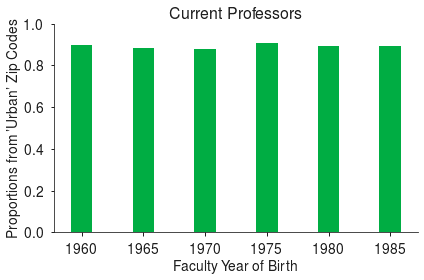

In [32]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE, sharey=True)

rural_props = [ruca_year['rural'] for ruca_year in ruca_trend]
urban_props = [ruca_year['urban'] for ruca_year in ruca_trend]
N = len(ruca_trend)

ind = np.arange(N) 
width = 0.35       
ax.bar(ind, urban_props, width, label='Professors', color = plot_utils.ACCENT_COLOR)
# plt.bar(ind + width, urban_props, width, label='Urban')
ax.set_ylim(0, 1)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels([1960, 1965, 1970, 1975, 1980, 1985])
ax.set_ylabel("Proportions from 'Urban' Zip Codes")
ax.set_xlabel('Faculty Year of Birth')
ax.set_title('Current Professors', fontsize=plot_utils.TITLE_SIZE)

plot_utils.finalize(ax)

plt.tight_layout()
plt.savefig('../plots/ruca_generation.pdf', dpi=1000)